In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import transformers
from transformers import LayoutLMForTokenClassification, AutoTokenizer
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torch.utils.data import DataLoader
from torcheval.metrics.functional import multiclass_f1_score
from PIL import ImageDraw, Image, ImageFont
import seaborn as sns

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")
    
from src.metrics import confusion_matrix
from src.preprocessing.make_dataset import ImageLayoutDataset
from src.model.trainer import LayoutLMTrainer

/users/eleves-a/2022/pedro.silva/few-shot-learning-transformers/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
!mkdir logs

mkdir: cannot create directory ‘logs’: File exists


In [4]:
model_name = "layoutlm"
dataset_name = "funsd"

In [5]:
logging.basicConfig(filename='logs/layoutlm_funsd.log', encoding='utf-8', level= logging.INFO)

## Obtaining data

In [6]:
dataset = load_dataset("nielsr/funsd")

In [7]:
llm_tokenizer = AutoTokenizer.from_pretrained("microsoft/layoutlm-base-uncased",)

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 149
    })
    test: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 50
    })
})

In [9]:
n_classes = len(dataset['train'].features['ner_tags'].feature.names)
n_classes

7

In [10]:
train_dataset = ImageLayoutDataset(
    dataset['train'],
    llm_tokenizer    
)

 32%|███▏      | 48/149 [00:00<00:00, 121.42it/s]

100%|██████████| 149/149 [00:01<00:00, 132.81it/s]


In [11]:
validation_dataset = ImageLayoutDataset(
    dataset['test'],
    llm_tokenizer    
)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:00<00:00, 125.24it/s]


In [12]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle = True
)

validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=1,
    shuffle = True
)

## Importing model

In [13]:
device = "cuda"

In [14]:
layoutlm = LayoutLMForTokenClassification.from_pretrained('microsoft/layoutlm-base-uncased', num_labels = n_classes)
layoutlm.to(device)

Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LayoutLMForTokenClassification(
  (layoutlm): LayoutLMModel(
    (embeddings): LayoutLMEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 768)
      (y_position_embeddings): Embedding(1024, 768)
      (h_position_embeddings): Embedding(1024, 768)
      (w_position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LayoutLMEncoder(
      (layer): ModuleList(
        (0-11): 12 x LayoutLMLayer(
          (attention): LayoutLMAttention(
            (self): LayoutLMSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
 

In [15]:
print(f'''
    Model Info
    -----------------
    
    Treinable params: {sum(p.numel() for p in layoutlm.parameters() if p.requires_grad)}
    Non Treinable params: {sum(p.numel() for p in layoutlm.parameters() if not p.requires_grad)}

''')


    Model Info
    -----------------
    
    Treinable params: 112633351
    Non Treinable params: 0




In [16]:
trainer = LayoutLMTrainer(
    layoutlm,
)

In [17]:
trainer.compile(
    train_dataloader,
    validation_dataloader,
    n_classes= n_classes,
    device = "cuda"
)

/users/eleves-a/2022/pedro.silva/few-shot-learning-transformers/.venv/lib64/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:50<00:00,  5.09s/it]


In [18]:
best_idx = None
for idx, f1 in enumerate(trainer.history['validation-f1']):
    if f1 == trainer.best_f1:
        best_idx = idx 

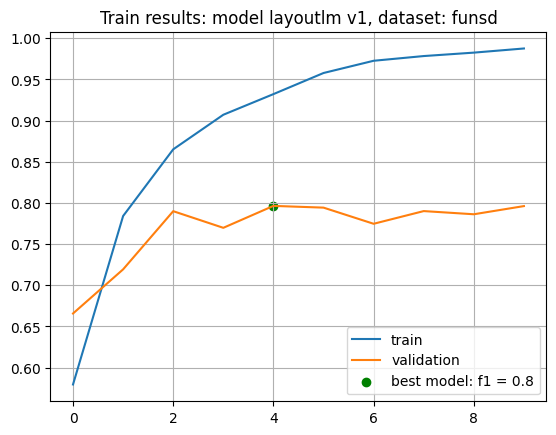

In [19]:
plt.plot(trainer.history['train-f1'],
         label = "train")
plt.plot(trainer.history['validation-f1'],
         label = "validation")

plt.title(f"Train results: model {trainer.model_name}, dataset: {dataset_name}")
plt.scatter(
    best_idx,
    trainer.best_f1.item(), 
    color = "green",
    label = f"best model: f1 = {round(trainer.best_f1.item(), 2)}"
)
plt.grid()
plt.legend()

In [20]:
trainer.history['validation-f1']

[0.6657716631889343,
 0.719355583190918,
 0.7899836897850037,
 0.7697875499725342,
 0.7964043021202087,
 0.7943030595779419,
 0.7746906280517578,
 0.7901003956794739,
 0.786247968673706,
 0.7961708903312683]

In [21]:
trainer.history['train-f1']

[0.5795794129371643,
 0.784129798412323,
 0.8650904297828674,
 0.9070680141448975,
 0.9321237802505493,
 0.9577600955963135,
 0.9726109504699707,
 0.9783361554145813,
 0.9824949502944946,
 0.9875358939170837]

## Performance analysis

### Distribution of errors

In [22]:
feature_names = dataset['train'].features['ner_tags'].feature.names
keymap = {i : v for i, v in enumerate(feature_names)}

In [23]:
y_pred, y_true = trainer.evaluate(validation_dataloader)

In [24]:
errors = y_pred[y_pred != y_true ]

In [25]:
conf_matrix = confusion_matrix(
    y_pred,
    y_true,
    n_classes,
    keymap
    
)

Text(0.5, 1.0, 'Confusion matrix- model: layoutlm, dataset : funsd')

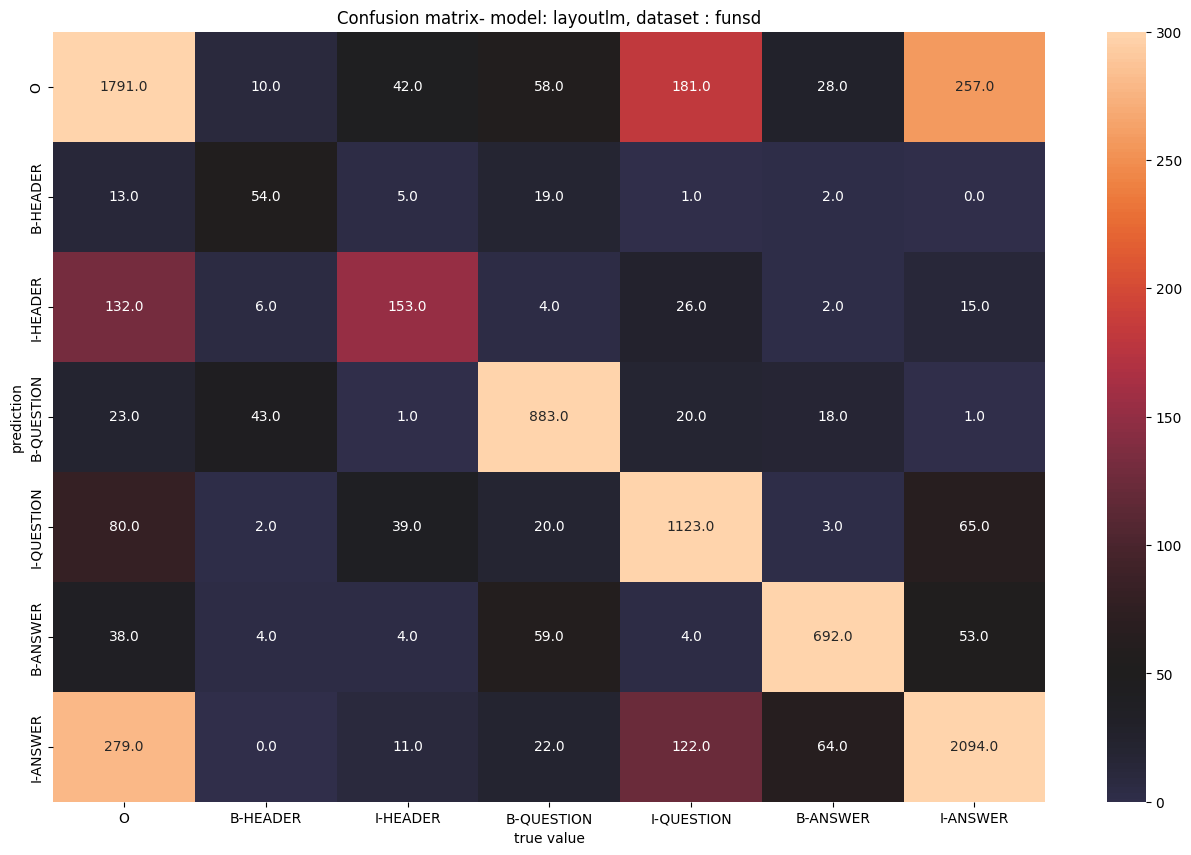

In [28]:
plt.figure(figsize=(16,10))
sns.heatmap(conf_matrix,
            annot=True,
            vmax=300,
            center= 50,
            fmt = '.1f')

plt.title(f"Confusion matrix- model: {model_name}, dataset : {dataset_name}")

### Verifying an image

In [ ]:
def unnormalize_bbox(bbox, width, height):
    return [
        int( (bbox[0] * width /1000)),
        int((bbox[1] * height /1000)),
        int((bbox[2] * width /1000)),
        int((bbox[3] * height / 1000)),
    ]

In [ ]:
font = ImageFont.load_default()

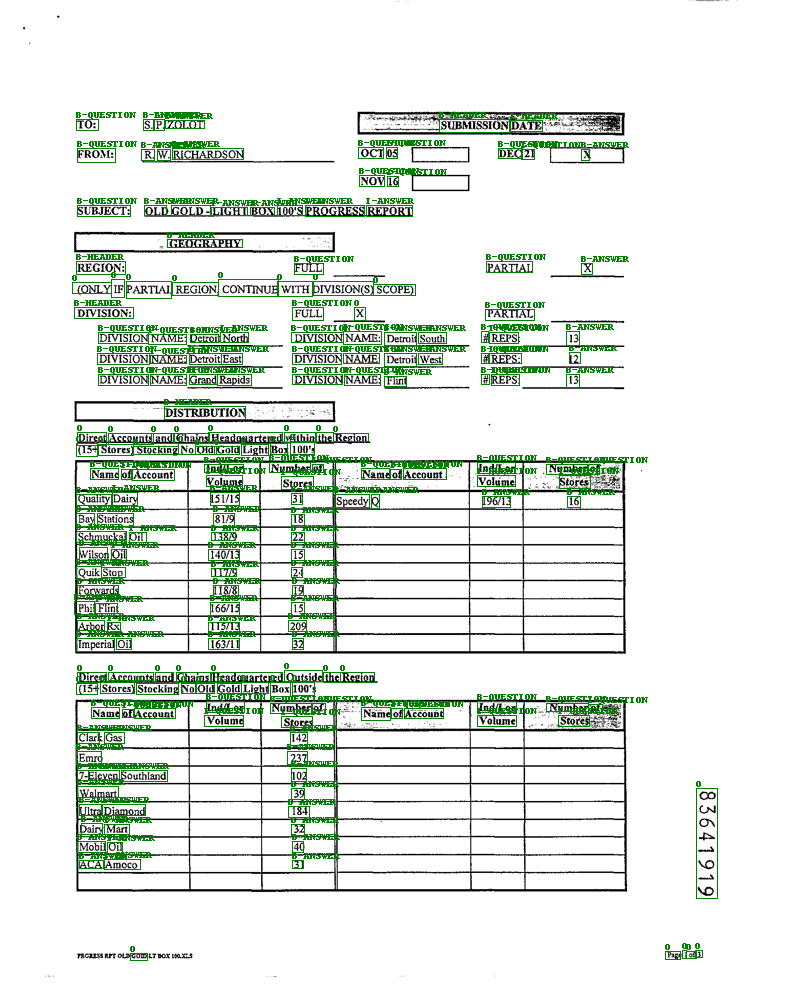

In [ ]:
img_idx = 20
example = train_dataset.encode(dataset['test'][img_idx])


unnormalized_box = [
    unnormalize_bbox(b, img.width, img.height) for b in dataset['test'][img_idx]['bboxes']
]

real_boxes = torch.tensor(
    unnormalized_box,
    device="cuda",
)

y_pred, y_true = trainer.evaluate(
    example
)

target = example['labels'].to("cuda")
mask = [target!= -100]
target = target

boxes = example['bbox'].to("cuda")

img = Image.open(dataset['test'][img_idx]['image_path'],)
rgbimg = Image.new("RGB", img.size)
rgbimg.paste(img)

img = rgbimg
new_img = img.copy()

for idx, box in enumerate(real_boxes):
    # if y_true[idx] == y_pred[idx]:
    #     continue

    draw = ImageDraw.Draw(img,)
    coordinates =  list(box.to("cpu").numpy())
    draw.rectangle(
        coordinates,
        outline= "green"
    )
    draw.text(
        [coordinates[0], coordinates[1] - 10], 
        keymap[y_true[idx].item()], 
        font= font,
        fill = "green"
    )

    draw2 = ImageDraw.Draw(new_img,)
    coordinates =  list(box.to("cpu").numpy())
    draw2.rectangle(
        coordinates,
        outline = "red"
    )
    draw2.text(
        [coordinates[0], coordinates[1] - 10], 
        keymap[y_pred[idx].item()], 
        font= font,
        fill = "red"
    )


img

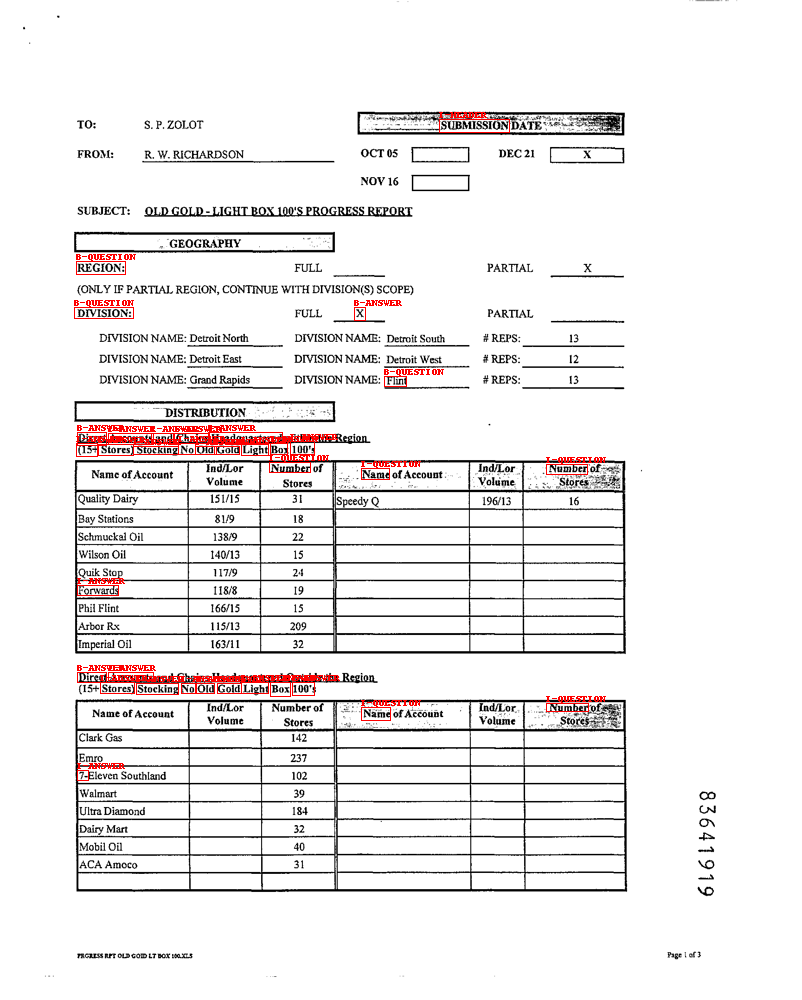

In [ ]:
new_img